In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Activation, Conv2D, Flatten, MaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
plt.style.use('dark_background')

In [2]:
x_train = np.load('/content/x_train.npy').astype(np.float32)
y_train = np.load('/content/y_train.npy').astype(np.float32)
x_val = np.load('/content/x_val.npy').astype(np.float32)
y_val = np.load('/content/y_val.npy').astype(np.float32)

In [3]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(2586, 26, 34, 1) (2586, 1)
(288, 26, 34, 1) (288, 1)


In [ ]:
plt.subplot(2, 1, 1)

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(
    x=x_train, y=y_train,
    batch_size=32,
    shuffle=True
)

val_generator = val_datagen.flow(
    x=x_val, y=y_val,
    batch_size=32,
    shuffle=False
)

In [5]:
inputs = Input(shape=(26, 34, 1))

net = Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(inputs)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=2)(net)

net = Flatten()(net)

net = Dense(512)(net)
net = Activation('relu')(net)
net = Dense(1)(net)
outputs = Activation('sigmoid')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 26, 34, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 34, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 17, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 17, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 8, 128)         73856 

In [6]:
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

model.fit_generator(
    train_generator, epochs=50, validation_data=val_generator,
    callbacks=[
        ModelCheckpoint('models/%s.h5' % (start_time), monitor='val_acc', save_best_only=True, mode='max', verbose=1),
        ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)
    ]
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


81/81 [==============================] - ETA: 0s - loss: 0.4483 - acc: 0.7780
Epoch 1: val_acc improved from -inf to 0.91667, saving model to models/2022_03_22_08_47_23.h5
81/81 [==============================] - 12s 24ms/step - loss: 0.4483 - acc: 0.7780 - val_loss: 0.2083 - val_acc: 0.9167 - lr: 0.0010
Epoch 2/50
81/81 [==============================] - ETA: 0s - loss: 0.2118 - acc: 0.9165
Epoch 2: val_acc improved from 0.91667 to 0.94097, saving model to models/2022_03_22_08_47_23.h5
81/81 [==============================] - 2s 20ms/step - loss: 0.2118 - acc: 0.9165 - val_loss: 0.1364 - val_acc: 0.9410 - lr: 0.0010
Epoch 3/50
80/81 [============================>.] - ETA: 0s - loss: 0.1840 - acc: 0.9385
Epoch 3: val_acc improved from 0.94097 to 0.96875, saving model to models/2022_03_22_08_47_23.h5
81/81 [==============================] - 2s 20ms/step - loss: 0.1824 - acc: 0.9393 - val_loss: 0.0874 - val_acc: 0.9688 - lr: 0.0010
Epoch 4/50
79/81 [============================>.] - ETA:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


test acc: 1.0


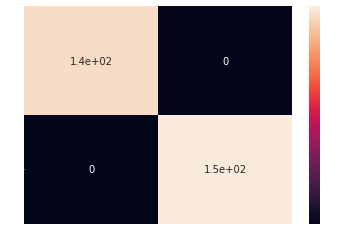

In [7]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

model = load_model('models/%s.h5' % (start_time))

y_pred = model.predict(x_val/255.)
y_pred_logical = (y_pred > 0.5).astype(np.int)

print ('test acc: %s' % accuracy_score(y_val, y_pred_logical))
cm = confusion_matrix(y_val, y_pred_logical)
sns.heatmap(cm, annot=True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


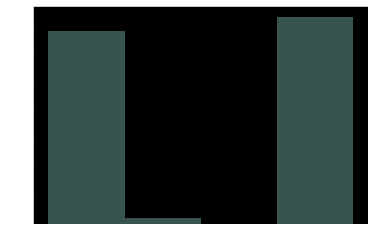

In [8]:
ax = sns.distplot(y_pred, kde=False)

In [16]:
import cv2, dlib
import numpy as np
from imutils import face_utils
from keras.models import load_model
from google.colab.patches import cv2_imshow

IMG_SIZE = (34, 26)

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/shape_predictor_68_face_landmarks.dat')

model = load_model('/content/models/2022_03_22_08_47_23.h5')
model.summary()

def crop_eye(img, eye_points):
  x1, y1 = np.amin(eye_points, axis=0)
  x2, y2 = np.amax(eye_points, axis=0)
  cx, cy = (x1 + x2) / 2, (y1 + y2) / 2

  w = (x2 - x1) * 1.2
  h = w * IMG_SIZE[1] / IMG_SIZE[0]

  margin_x, margin_y = w / 2, h / 2

  min_x, min_y = int(cx - margin_x), int(cy - margin_y)
  max_x, max_y = int(cx + margin_x), int(cy + margin_y)

  eye_rect = np.rint([min_x, min_y, max_x, max_y]).astype(np.int)

  eye_img = gray[eye_rect[1]:eye_rect[3], eye_rect[0]:eye_rect[2]]

  return eye_img, eye_rect

# main
cap = cv2.VideoCapture('/content/eye_test.mp4')

while cap.isOpened():
  ret, img_ori = cap.read()

  if not ret:
    break

  img_ori = cv2.resize(img_ori, dsize=(0, 0), fx=0.5, fy=0.5)

  img = img_ori.copy()
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  faces = detector(gray)

  for face in faces:
    shapes = predictor(gray, face)
    shapes = face_utils.shape_to_np(shapes)

    eye_img_l, eye_rect_l = crop_eye(gray, eye_points=shapes[36:42])
    eye_img_r, eye_rect_r = crop_eye(gray, eye_points=shapes[42:48])

    eye_img_l = cv2.resize(eye_img_l, dsize=IMG_SIZE)
    eye_img_r = cv2.resize(eye_img_r, dsize=IMG_SIZE)
    eye_img_r = cv2.flip(eye_img_r, flipCode=1)

    cv2_imshow(eye_img_l)
    cv2_imshow(eye_img_r)

    eye_input_l = eye_img_l.copy().reshape((1, IMG_SIZE[1], IMG_SIZE[0], 1)).astype(np.float32) / 255.
    eye_input_r = eye_img_r.copy().reshape((1, IMG_SIZE[1], IMG_SIZE[0], 1)).astype(np.float32) / 255.

    pred_l = model.predict(eye_input_l)
    pred_r = model.predict(eye_input_r)

    # visualize
    state_l = 'O %.1f' if pred_l > 0.1 else '- %.1f'
    state_r = 'O %.1f' if pred_r > 0.1 else '- %.1f'

    state_l = state_l % pred_l
    state_r = state_r % pred_r

    cv2.rectangle(img, pt1=tuple(eye_rect_l[0:2]), pt2=tuple(eye_rect_l[2:4]), color=(255,255,255), thickness=2)
    cv2.rectangle(img, pt1=tuple(eye_rect_r[0:2]), pt2=tuple(eye_rect_r[2:4]), color=(255,255,255), thickness=2)

    cv2.putText(img, state_l, tuple(eye_rect_l[0:2]), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)
    cv2.putText(img, state_r, tuple(eye_rect_r[0:2]), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)

  cv2_imshow(img)
  if cv2.waitKey(1) == ord('q'):
    break

Output hidden; open in https://colab.research.google.com to view.